# Quantum Neural Network 

In this tutorial we will explore the use of quantum neural networks in time series function forecasting using PennyLane. We will develop a variational circuit which is a continuous variable quantum neural network that learns to fit a one dimensional function by making predictions. The predictions will be the expectation value of the quantum node

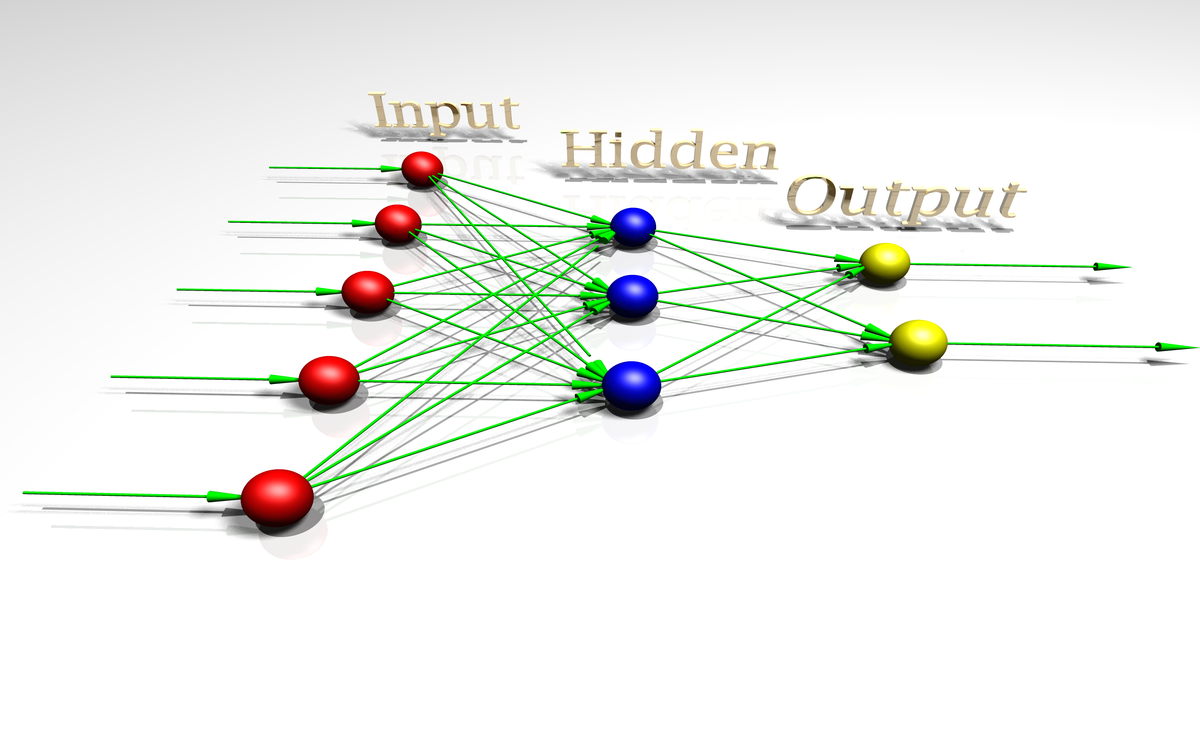

A quantum neural network (QNN) is a computational machine learning model that involves combining artificial neural networks and quantum information to develop more efficient algorithms. Currently, classical neural networks are challenging to train efficiently if the dimension of data is large. Quantum neural networks can be achieved by adding a quantum convolutional layer or simulating each perceptron as a qubit. The applications of QNNs are often in tasks which require variational or parametrized circuits and training of these neural networks happen in optimization algorithms. This is a type of programming known as differentiable computing.

The computation is implemented using continuous functions and caluclating their gradient or derivatives. The gradients represent the rate at which to change the parameters of variational circuits so as to output expected value.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import numpy as np
import pylab
import matplotlib as mpl

We will import the time series dataset. It should be placed in the same folder as this code. The dataset will be attached on Github.

### Step 1: Load the function in appropriate format

In [ ]:
data = np.loadtxt("sine.txt")
X = np.array(data[:, 0], requires_grad=False)
Y = np.array(data[:, 1], requires_grad=False)

Define the device to run the program. We will be using strawberryfields.fock, with 1 qubit or wire

In [ ]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

### Step 2: Define the quantum node 

We will define the quantum layer using the algorithm presented in this paper https://arxiv.org/abs/1806.06871

In [ ]:
def layer(v):
    # Matrix multiplication of inputs
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # nonlinear transformation
    qml.Kerr(v[4], wires=0)

### Step 3: Create the Quantum Neural Network 

We will encode the input x into a quantum state and execute the layers which will act as sub circuit of the neural network

In [ ]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into a quantum state
    qml.Displacement(x, 0.0, wires=0)

    #call layer(v) which will be the subcircuit of the variational circuit of the neural network
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Step 4: Define the objective function 

The objective will be the square loss between target labels and model prediction and the cost function will be the square loss of the given data or labels and predicted outputs from the quantum neural network which will be the expected value of the quantum node

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

### Step 5: Define the neural network parameters and weights 

The weights of the network will be defined with values that are generated from the np.random.randn function will follows a normal distribution

In [ ]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

### Step 6: Update the weights using optimizer 

Using the Adam optimizer, we update the weights for 500 steps . More steps will lead to a better fit.

In [ ]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    var, _cost = opt.step_and_cost(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

### Step 7: Output and process the predictions of the quantum neural network 

We will use the values of the predictions in the range [-1,1]

In [ ]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x_) for x_ in x_pred

We will plot the shape of the function that the quantum neural network has “learned” from the function and the predicted values.  The green dots represent the model's predictions and the blue dots is what the actual function was

In [ ]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

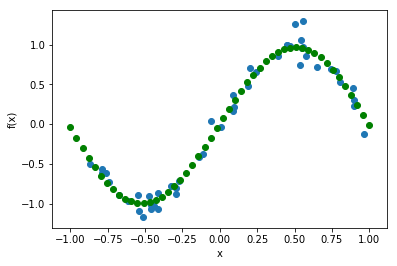

We can see that the quantum neural network was accurate in predicting f(x) for a particular x by developing a variational circuit and varying the parameters or the weights using the Adam optimizer